In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

nrows = 100  
ncols = 60

save_dir = 'drive/My Drive/Checkpoints/v6.1.1_vgg/'
model_name = 'v6.1.1_vgg.h5'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, model_name)

data_in = read_csv('drive/My Drive/Colab Rainfall/cdr_train_98_13.csv', header=None, index_col=0)
data_out = read_csv('drive/My Drive/Colab Rainfall/aphro_train_98_13.csv', header=None, index_col=0)

print('Data shape:', data_in.shape, data_out.shape)

In [ ]:
def reshape_data(data_re):
  dataRE = []
  for ix in range(len(data_re)):
    _x = data_re[ix: ix+1].values.reshape((nrows, ncols))
    dataRE.append(_x)
  return dataRE

print(data_in.shape, data_out.shape)
data_in_re = reshape_data(data_in)
data_out_re = reshape_data(data_out)   

size_train = 5113          
def split_data(data_org):
  train_org = data_org[0: size_train]
  valid_org = data_org[size_train: len(data_org)]
  return train_org, valid_org
                                
train_x, valid_x = split_data(data_in_re)
train_y, valid_y = split_data(data_out_re)

print('train shape:', np.shape(train_x), np.shape(train_y)) 
print('valid shape:', np.shape(valid_x), np.shape(valid_y))

(5844, 6000) (5844, 6000)
train shape: (5113, 100, 60) (5113, 100, 60)
valid shape: (731, 100, 60) (731, 100, 60)


Show the sample train data: 240


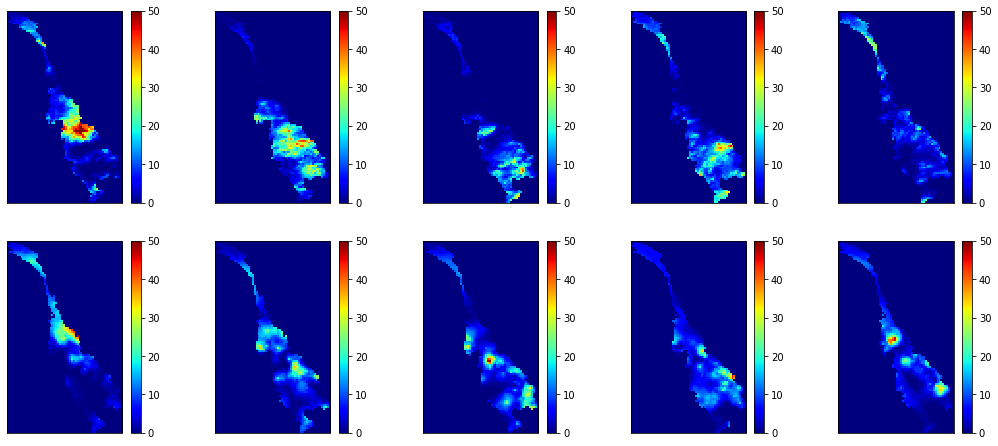

In [ ]:
num = 5
idx = 240
rain_max = 50      
save_name = 'save_name'
def show_sample(sam_1, sam_2=None):
  plt.figure(figsize=(20, 12))       
  color = 'jet'                 
  for i in range(num):
    ax = plt.subplot(3, num, i+1)
    plt.imshow(sam_1[i+idx].reshape(nrows, ncols), cmap=color, vmin=0, vmax=rain_max)
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    if sam_2 is not None:
      ax = plt.subplot(3, num, i+1+num)
      plt.imshow(sam_2[i+idx].reshape(nrows, ncols), cmap=color, vmin=0, vmax=rain_max)
      plt.colorbar()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.savefig(save_name)
  plt.show()

print('Show the sample train data:', idx)
save_name = 'drive/My Drive/Checkpoints/v6.1.1_vgg/show_sam_train.png'
show_sample(train_x, train_y)


In [ ]:
scaler = MinMaxScaler()
def scaled_train(scale_x, scale_y):
  scale_x = np.reshape(scale_x, (len(scale_x), nrows*ncols))
  scale_y = np.reshape(scale_y, (len(scale_y), nrows*ncols))
  scale_z = np.concatenate((scale_x, scale_y), axis=0)
  z_scale = scaler.fit_transform(scale_z)
  x_scale, y_scale = np.vsplit(z_scale, 2)
  x_scale = np.reshape(x_scale, (len(x_scale), nrows, ncols, 1))
  y_scale = np.reshape(y_scale, (len(y_scale), nrows, ncols, 1))
  return x_scale, y_scale

def scaled_valid(scale_x, scale_y):
  scale_x = np.reshape(scale_x, (len(scale_x), nrows*ncols))
  scale_y = np.reshape(scale_y, (len(scale_y), nrows*ncols))
  scale_z = np.concatenate((scale_x, scale_y), axis=0)
  z_scale = scaler.transform(scale_z)
  x_scale, y_scale = np.vsplit(z_scale, 2)
  x_scale = np.reshape(x_scale, (len(x_scale), nrows, ncols, 1))
  y_scale = np.reshape(y_scale, (len(y_scale), nrows, ncols, 1))
  return x_scale, y_scale

train_X, train_Y = scaled_train(train_x, train_y)
valid_X, valid_Y = scaled_valid(valid_x, valid_y)

print('Shape for train:', train_X.shape, train_Y.shape)
print('Shape for valid:', valid_X.shape, valid_Y.shape)
print(train_Y[idx].reshape(nrows, ncols))

In [ ]:
# STRUCTURE (4 BLOCKS)
from keras.layers import Input, Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.utils import plot_model
np.random.seed(8)
tf.set_random_seed(8)

model = Sequential()
input_shape = (nrows, ncols, 1)
n_filters = 32
drop_rate = 0.1

model.add(Conv2D(n_filters, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(n_filters, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(n_filters*2, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(n_filters*2, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(n_filters*4, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(n_filters*4, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(n_filters*8, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(n_filters*8, (3, 3), padding='same', activation='relu'))

model.add(UpSampling2D((2, 2)))
model.add(Conv2D(n_filters*4, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(n_filters*4, (3, 3), padding='same', activation='relu'))

model.add(UpSampling2D((2, 2)))
model.add(Conv2D(n_filters*2, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(n_filters*2, (3, 3), activation='relu'))

model.add(UpSampling2D((2, 2)))
model.add(Conv2D(n_filters, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(n_filters, (3, 3), padding='same', activation='relu'))

model.add(Conv2D(1, (3, 3), padding='same', activation='relu'))   # linear, relu, sigmoid

adam = optimizers.Adam(lr=0.001)
model.compile(optimizer= adam, 
              loss='mse', 
              metrics=['accuracy'])

print(model.summary())

In [ ]:
from IPython.display import Image
Image(retina=True, filename='drive/My Drive/Checkpoints/v6.1.1_vgg/6.1_vgg_100x60.png')

In [ ]:
min_required = 1e-5       
num_improvement = 50      
num_period = 10            
num_epochs = 5000
batch_size = 32

es = EarlyStopping(monitor='loss',
                   min_delta= min_required,
                   patience=num_improvement,
                   verbose=1,
                   mode='min')

mc = ModelCheckpoint(filepath=save_path,
                     monitor='loss', 
                     verbose=1, 
                     save_best_only=True,  
                     mode='max',
                     period=num_period)

model.fit(train_X, train_Y, 
          epochs = num_epochs,
          batch_size = batch_size,
          shuffle=True,
          verbose=0,
          validation_data=(valid_X, valid_Y),
          callbacks=[es, mc])

print(model.history.history.keys())

In [ ]:
print('The last epoch:', es.stopped_epoch+1 )
print('Finish training at epoch:', es.stopped_epoch+1-num_improvement)

saved_model = load_model('drive/My Drive/Checkpoints/v6.1.1_vgg/v6.1.1_vgg.h5')

# Evaluate the model
_, train_acc = model.evaluate(train_X, train_Y, verbose=0)
_, valid_acc = model.evaluate(valid_X, valid_Y, verbose=0)
print('Train Acc: %.3f, Valid Acc: %.3f' % (train_acc, valid_acc))

acc = model.history.history['acc']
loss = model.history.history['loss']
val_acc = model.history.history['val_acc']
val_loss = model.history.history['val_loss']

# summarize history for accuracy
plt.figure(num = 1, figsize = (10, 5))
plt.plot(acc, '--', label='Train_acc')
plt.plot(val_acc, label='Valid_acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.savefig('drive/My Drive/Checkpoints/v6.1.1_vgg/history_acc.png')
plt.show()


In [ ]:
# Define a function for showing images
n = 6
sam_idx = 200
save_name = 'save_name'
def show_sample_imgs(sam_img1, sam_img2=None, sam_img3=None):
  plt.figure(figsize=(20, 12))
  color = 'jet'           
  for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(sam_img1[i+sam_idx].reshape(nrows, ncols), cmap=color)
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if sam_img2 is not None:
      ax = plt.subplot(3, n, i+1+n)
      plt.imshow(sam_img2[i+sam_idx].reshape(nrows, ncols), cmap=color)
      plt.colorbar()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    if sam_img3 is not None:
      ax = plt.subplot(3, n, i+1+2*n)
      plt.imshow(sam_img3[i+sam_idx].reshape(nrows, ncols), cmap=color)
      plt.colorbar()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.savefig(save_name)
  plt.show()

valid_scores = model.evaluate(valid_X, valid_Y)
print('Validation Accuracy: {}%'.format(np.around(valid_scores[1]*100, decimals=2)))

valid_pred = model.predict(valid_X)
valid_pred_invert = scaler.inverse_transform(valid_pred.reshape(len(valid_pred), nrows*ncols))
#valid_pred_invert = valid_pred
valid_pred_invert = np.around(valid_pred_invert, 3)
valid_pred_invert = valid_pred_invert.reshape(len(valid_pred_invert), nrows, ncols)
print(valid_pred_invert.shape)

# Calculate on full predicted data
valid_pred_invert_re = valid_pred_invert.reshape(len(valid_pred), nrows*ncols)
valid_x_re = np.reshape(valid_x, (len(valid_x), nrows*ncols))
valid_y_re = np.reshape(valid_y, (len(valid_y), nrows*ncols))

valid_mae = mean_absolute_error(valid_y_re, valid_pred_invert_re)
valid_mse = mean_squared_error(valid_y_re, valid_pred_invert_re)
valid_rmse = np.sqrt(valid_mse)
valid_r2 = r2_score(valid_y_re, valid_pred_invert_re)

print('Valid RMSE = {}'. format(np.around(valid_rmse, decimals=2)), '(mm)')
print('Valid MAE = %.2f' % valid_mae, '(mm)')
print('Valid MSE = %.2f' % valid_mse)
print('Valid NSE = {}%'.format(np.around(valid_r2, decimals=2)))

print('show sample valid:', sam_idx)
save_name = 'drive/My Drive/Checkpoints/v6.1.1_vgg/show_sam_compare_valid.png'
show_sample_imgs(valid_x, valid_pred_invert, valid_y)

print('Max value of valid_pred', np.around(valid_pred_invert_re.max(), 2))
print('Max value of valid_obs', np.around(valid_y_re.max(), 2))


In [ ]:
# CALCULATE ERROR: RMSE and MAE on VALIDATION DATASET
# Define a funtion to calculate error monthly
def cal_error_month_average(data_x, data_y):
  MAE_am = []
  RMSE_am = []
  for i in range (len(data_x)):
    if i%30 == 0:
      am_mae = mean_absolute_error(data_x[i: i+30], data_y[i: i+30])
      am_rmse = np.sqrt(mean_squared_error(data_x[i: i+30], data_y[i: i+30]))
    MAE_am.append(np.around(am_mae, 2))
    RMSE_am.append(np.around(am_rmse, 2))
  return MAE_am, RMSE_am

valid_am_mae_org, valid_am_rmse_org = cal_error_month_average(valid_y_re, valid_x_re)
valid_am_mae_pred, valid_am_rmse_pred = cal_error_month_average(valid_y_re, valid_pred_invert_re)

# summarize mae error
plt.figure(num = 5, figsize = (15, 5))
plt.plot(day_valid, valid_am_mae_org, label='avg_month_MAE_org')
plt.plot(day_valid, valid_am_mae_pred, label='avg_month_MAE_pred')
plt.title('Valid MAE_monthly (30 days)')
plt.legend()
plt.xlim(0)
plt.xlabel('Time (day)')
plt.ylabel('MAE (mm)')
plt.savefig('drive/My Drive/Checkpoints/v6.1.1_vgg/valid_monthly_MAE.png')
plt.show()

print('Average original MAE', np.around(np.average(valid_mae_org), 2), 'mm')
print('Average predicted MAE', np.around(np.average(valid_mae_pred), 2), 'mm')

# summarize rmse error
plt.figure(num = 6, figsize = (15, 5))
plt.plot(day_valid, valid_am_rmse_org, label='avg_month_RMSE_org')
plt.plot(day_valid, valid_am_rmse_pred, label='avg_month_RMSE_pred')
plt.title('Valid RMSE_monthly (30 days)')
plt.legend()
plt.xlim(0)
plt.xlabel('Time (day)')
plt.ylabel('RMSE (mm)')
plt.savefig('drive/My Drive/Checkpoints/v6.1.1_vgg/valid_monthly_RMSE.png')
plt.show()


# TEST Dataset

In [ ]:
# *** CREATE a test data file FOR FORECASTING ***
test_in = read_csv('drive/My Drive/Colab Rainfall/cdr_test_14_15.csv', header=None, index_col=0)
test_out = read_csv('drive/My Drive/Colab Rainfall/aphro_test_14_15.csv', header=None, index_col=0)

test_x = reshape_data(test_in)
test_y = reshape_data(test_out)

test_X, test_Y = scaled_valid(test_x, test_y)

idx = 120
print('Plot sample test data set:', idx)
save_name = 'drive/My Drive/Checkpoints/v6.1.1_vgg/show_sam_test.png'
show_sample(test_x, test_y)


[INFO] Calculating model accuracy
730/730 [==============================] - 0s 682us/step
Test Accuracy: 86.41%
(730, 100, 60)
Test RMSE = 2.07 (mm)
Test MAE = 0.46 (mm)
Test MSE = 4.29
Test NSE = 0.51%
1. satellite-input-test_x data
2. predicted data
3. observed-aphro-test_y data 
show sample test: 135


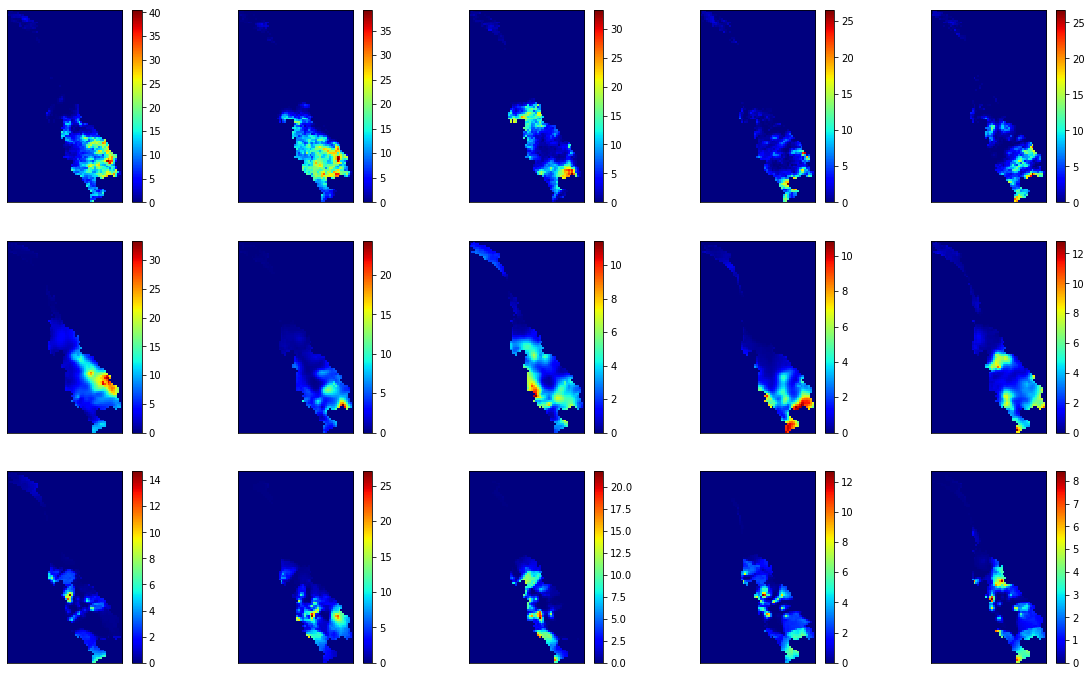

Max value of test_pred 119.593
Max value of test_obs 124.0


In [ ]:
# CALCULATE for TEST DATA
sam_idx = 135
test_scores = model.evaluate(test_X, test_Y)
print('Test Accuracy: {}%'.format(np.around(test_scores[1]*100, decimals=2)))

test_pred = model.predict(test_X)
test_pred_invert = scaler.inverse_transform(test_pred.reshape(len(test_pred), nrows*ncols))
test_pred_invert = np.around(test_pred_invert, 3)
test_pred_invert = test_pred_invert.reshape(len(test_pred_invert), nrows, ncols)
print(test_pred_invert.shape)

test_pred_invert_re = test_pred_invert.reshape(len(test_pred), nrows*ncols)
test_x_re = np.reshape(test_x, (len(test_x), nrows*ncols))
test_y_re = np.reshape(test_y, (len(test_y), nrows*ncols))

test_mae = mean_absolute_error(test_y_re, test_pred_invert_re)
test_mse = mean_squared_error(test_y_re, test_pred_invert_re)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_y_re, test_pred_invert_re)

print('Test RMSE = {}'. format(np.around(test_rmse, decimals=2)), '(mm)')
print('Test MAE = %.2f' % test_mae, '(mm)')
print('Test MSE = %.2f' % test_mse)
print('Test NSE = {}%'.format(np.around(test_r2, decimals=2)))

print('1. satellite-input-test_x data')
print('2. predicted data')
print('3. observed-aphro-test_y data ')

print('Plot sample test:', sam_idx)
save_name = 'drive/My Drive/Checkpoints/v6.1.1_vgg/show_sam_compare_test.png'
show_sample_imgs(test_x, test_pred_invert, test_y)

print('Max value of test_pred', test_pred_invert_re.max())
print('Max value of test_obs', test_y_re.max())


In [ ]:
# Define a function to calculate the cumulative rainfall per month
def sum_pr_monthly(data_x):
  sum_pr_m = []
  for i in range(len(data_x)):
    if i % 30 == 0:
      preci = np.sum(data_x[i: i+30])
    sum_pr_m.append(preci)
  return sum_pr_m

pr_test_sat_m = sum_pr_monthly(test_x_re)
pr_test_obs_m = sum_pr_monthly(test_y_re)
pr_test_pred_m = sum_pr_monthly(test_pred_invert_re)

title_name = 'Test - precipitation monthly (30 days)'
save_name = 'drive/My Drive/Checkpoints/v6.1.1_vgg/sum_pr_monthly_test.png'
visual_data(pr_test_sat_m, pr_test_obs_m, pr_test_pred_m)


In [ ]:
# SAVE FILE
np.savetxt('drive/My Drive/Checkpoints/v6.1.1_vgg/valid_pred.csv', valid_pred_invert_re, delimiter=',')
np.savetxt('drive/My Drive/Checkpoints/v6.1.1_vgg/valid_obs.csv', valid_y_re, delimiter=',')
np.savetxt('drive/My Drive/Checkpoints/v6.1.1_vgg/valid_org.csv', valid_x_re, delimiter=',')

np.savetxt('drive/My Drive/Checkpoints/v6.1.1_vgg/test_pred.csv', test_pred_invert_re, delimiter=',')
np.savetxt('drive/My Drive/Checkpoints/v6.1.1_vgg/test_obs.csv', test_y_re, delimiter=',')
np.savetxt('drive/My Drive/Checkpoints/v6.1.1_vgg/test_org.csv', test_x_re, delimiter=',')
